In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pydot
import os
from fnmatch import fnmatch
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm

# First param is project name, second is config name
LOCATION = "..\\out\\%s\\%s.csv"
# Params are project, datapoint, concepts
DATAPOINT = "..\\data\\corpora_clean\\%s\\%s\\%d\\merged.dot"
sns.set_style("whitegrid")
figsize=(5,4)
dpi=300
palette="dark"
# Fix plot fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
projects = [
    "Commandline",
    "CommonMark",
    "Hangfire",
    "Humanizer",
    "Lean",
    "Nancy",
    "Newtonsoft.Json",
    "Ninject",
    "RestSharp",
]
methods_ordered = ["WL c", "WL d", "WL n", "WL dc", "WL dn", "WL cn", "WL dcn"]

In [3]:
import itertools
l = [False, True]
configs = list(itertools.product(l, repeat=3))[1:]
df = pd.DataFrame(data=[], columns=['Datapoint','Concepts','Accuracy','Overlap','Time'])
for project in tqdm(projects):
    for with_data, with_call, with_name in tqdm(configs, leave=False):
        suffix = ""
        edges_kept = ""
        if with_data:
            suffix += "d"
            edges_kept += "data"
        if with_call:
            suffix += "c"
            edges_kept += "control"
        if with_name:
            suffix += "n"
            edges_kept += "name"
    
        try:
            location = LOCATION % (project, ("wl_%s_1_results_%s" % (edges_kept, suffix)))
            temp_df = pd.read_csv(location, index_col=False)
            temp_df['Project'] = pd.Series([project]*len(temp_df.index))
            temp_df['Method'] = pd.Series(["WL %s" % suffix]*len(temp_df.index))
            
            df = df.append(temp_df, sort=False)
        except FileNotFoundError:
            pass # If it's not there, it's not there yet :)
df['Method'] = pd.Categorical(df['Method'], methods_ordered)
df = df.sort_values('Method')
df

,Datapoint,Concepts,Accuracy,Overlap,Time,Project,Method
191,388d568c761ec1ca85a69b54098360475b98bf77_36642...,2,0.985000,0.97,61.829930,CommonMark,WL c
856,903c058fe268259679ecf8babf43c6889353bdb8_c5fab...,1,1.000000,NaN,0.209279,Commandline,WL c
857,a0dd60858fa483caf6cefffe62bb9c02641e0d8d_aaadf...,2,0.714286,NaN,0.262922,Commandline,WL c
858,a3cab1ca45126eb0b58bc8290e4406a487d61329_1c68c...,2,0.875000,NaN,0.273895,Commandline,WL c
859,2fbc90106ddd9569ef1714771df453db0a4e00a2_2224f...,1,1.000000,NaN,0.222345,Commandline,WL c
...,...,...,...,...,...,...,...
3,d66199d73fbe9d03fc296c188acc226ae7e8a9d8_d50a3...,2,0.859504,NaN,24.275608,Hangfire,WL dcn
4,0f63c80167ef863697760d1b293ea648b11ee4b2_1ce94...,1,1.000000,NaN,0.249564,Hangfire,WL dcn
5,a972440dba3cd0ffda177c71b03213ff962eff79_83d6e...,2,0.988372,NaN,11.108627,Hangfire,WL dcn
7,35b008cf586ad9ed442cc6854b4c20ccfdf16fd9_7d644...,1,1.000000,NaN,0.208941,Hangfire,WL dcn


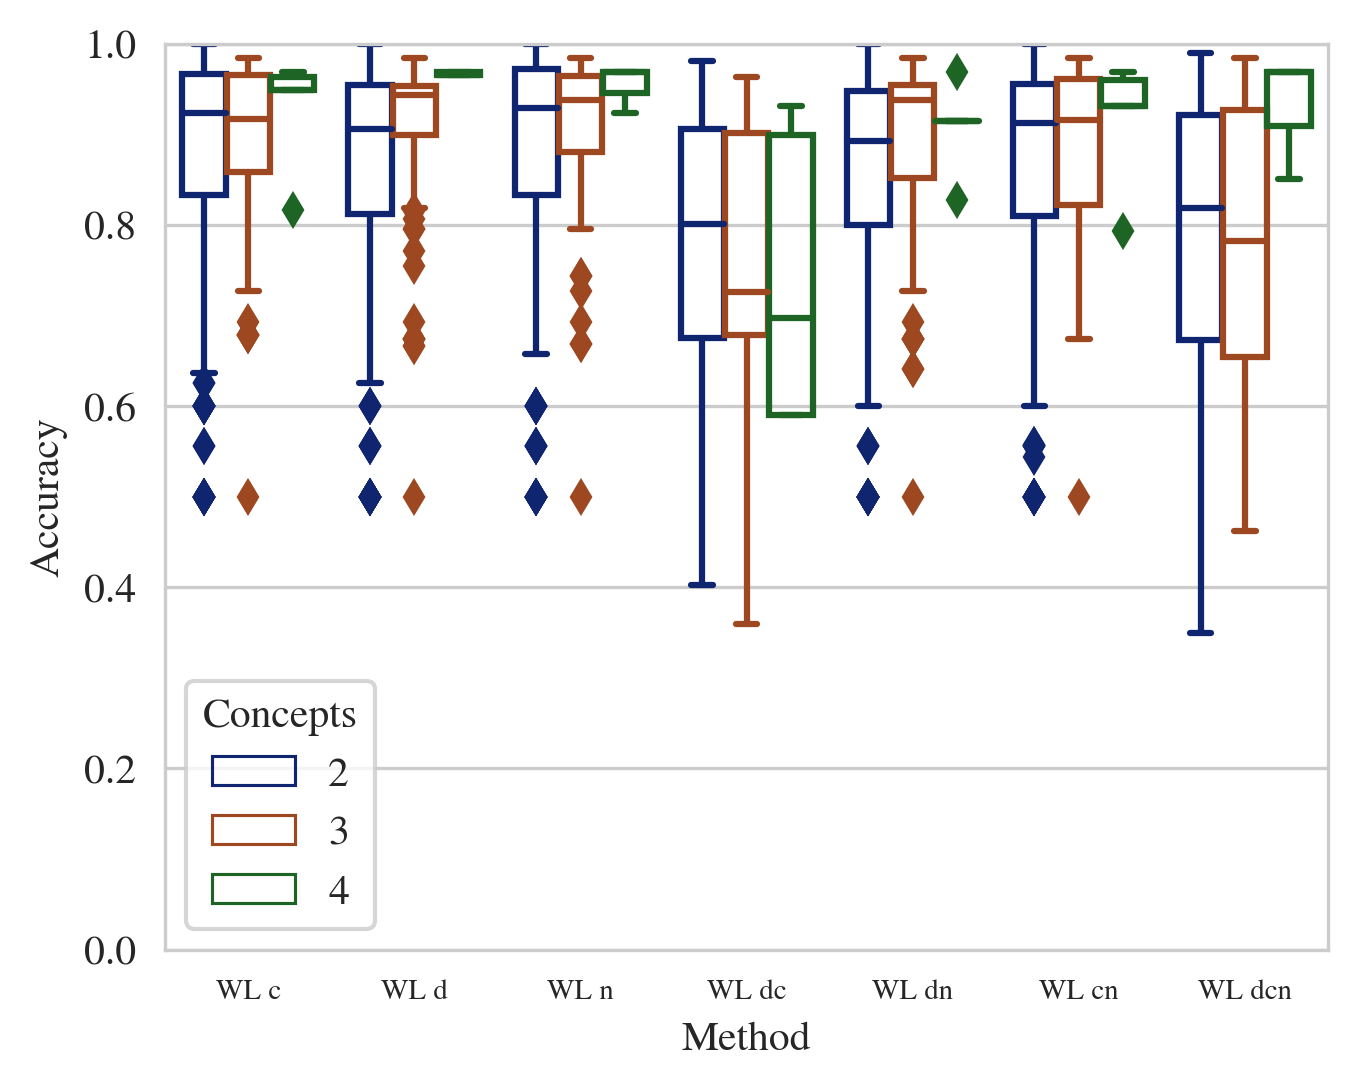

In [4]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Accuracy", hue="Concepts", palette=palette, ax=ax)
# sns.swarmplot(data=df[df.Concepts > 1], x="Method", y="Accuracy", palette=palette, alpha=.66, ax=ax)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
#     col = color_map[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
        
plt.xticks(
#     rotation=10,
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-small',
)

plt.ylim((-0.0,1.0))
    
plt.savefig("Accuracy_ablation.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

In [12]:
for m in methods_ordered:
    slice_ = df[df.Concepts > 1]
    slice_ = slice_[slice_.Method == m]
    print('%s: %2.3f' % (m, slice_.Accuracy.median()))
    for c in [2, 3, 4]:
        slice__ = slice_[slice_.Concepts == c]
        print('%s, %d: %2.3f' % (m, c, slice__.Accuracy.median()))

WL c: 0.923
WL c, 2: 0.923
WL c, 3: 0.917
WL c, 4: 0.949
WL d: 0.913
WL d, 2: 0.906
WL d, 3: 0.943
WL d, 4: 0.966
WL n: 0.933
WL n, 2: 0.929
WL n, 3: 0.938
WL n, 4: 0.969
WL dc: 0.800
WL dc, 2: 0.801
WL dc, 3: 0.726
WL dc, 4: 0.697
WL dn: 0.901
WL dn, 2: 0.893
WL dn, 3: 0.938
WL dn, 4: 0.915
WL cn: 0.913
WL cn, 2: 0.912
WL cn, 3: 0.916
WL cn, 4: 0.932
WL dcn: 0.818
WL dcn, 2: 0.818
WL dcn, 3: 0.782
WL dcn, 4: 0.969


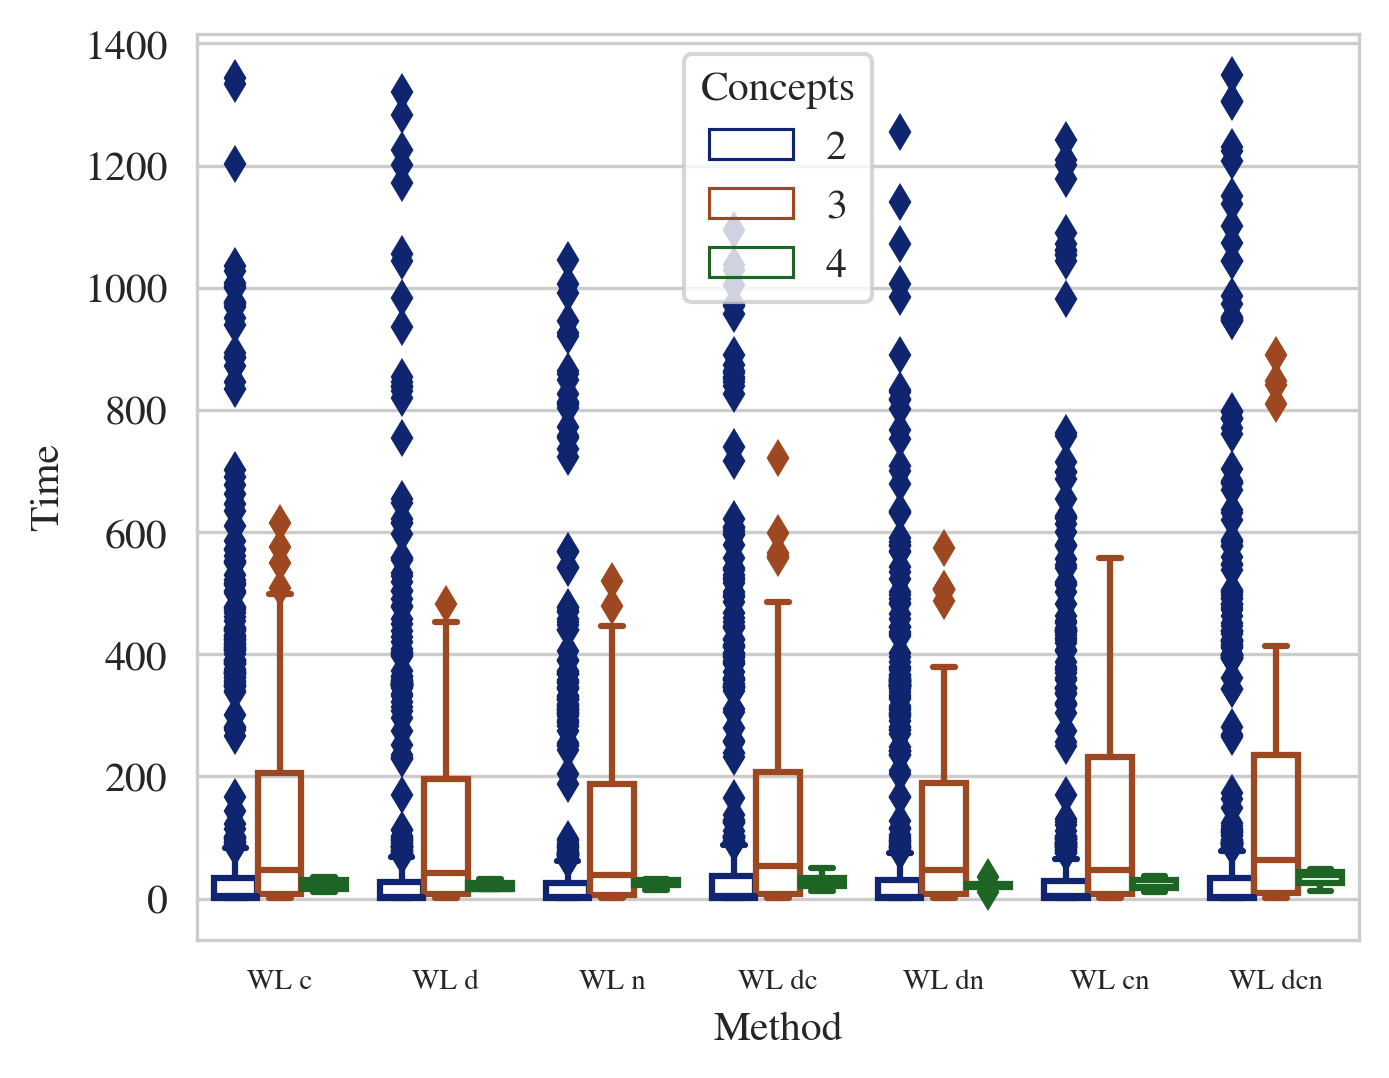

In [5]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Time", hue="Concepts", palette=palette, ax=ax)
# sns.swarmplot(data=df[df.Concepts > 1], x="Method", y="Accuracy", palette=palette, alpha=.66, ax=ax)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
#     col = color_map[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
        
plt.xticks(
#     rotation=10,
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-small',
)

# plt.ylim((0, 75))

plt.savefig("Time_ablation.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

In [6]:
results_atomic = dict()
for m in methods_ordered:
    wl_df = df[df.Method == m]
    atomic = (wl_df[wl_df.Concepts == 1].Overlap.isnull()).mean()
    multi = (wl_df[wl_df.Concepts > 1].Overlap.isnull()).mean()
    acc_atomic = acc = wl_df[wl_df.Concepts == 1].Accuracy.mean()
    acc = wl_df[wl_df.Concepts > 1].Accuracy.mean()
    time = wl_df.Time.mean()
    print('Method %s' % m)
    print('Correctly atomic:')
    print('%1.4f' % atomic)
    print('Incorrectly atomic:')
    print('%1.4f' % multi)
    print('Atomic graph labelling accuracy:')
    print('%1.4f' % acc_atomic)
    print('Untangle accuracy:')
    print('%1.4f' % acc)
    print('Untangle time:')
    print('%-1.4f' % time)
    print()
    results_atomic[m] = (atomic, 1 - multi, acc_atomic, acc, time)

Method WL c
Correctly atomic:
0.8733
Incorrectly atomic:
0.5713
Atomic graph labelling accuracy:
0.9896
Untangle accuracy:
0.8872
Untangle time:
37.6745

Method WL d
Correctly atomic:
0.7324
Incorrectly atomic:
0.4335
Atomic graph labelling accuracy:
0.9686
Untangle accuracy:
0.8775
Untangle time:
32.3748

Method WL n
Correctly atomic:
0.7904
Incorrectly atomic:
0.4842
Atomic graph labelling accuracy:
0.9838
Untangle accuracy:
0.8919
Untangle time:
28.8334

Method WL dc
Correctly atomic:
0.6098
Incorrectly atomic:
0.2840
Atomic graph labelling accuracy:
0.9150
Untangle accuracy:
0.7802
Untangle time:
34.1138

Method WL dn
Correctly atomic:
0.6961
Incorrectly atomic:
0.4050
Atomic graph labelling accuracy:
0.9612
Untangle accuracy:
0.8681
Untangle time:
32.3600

Method WL cn
Correctly atomic:
0.7796
Incorrectly atomic:
0.4570
Atomic graph labelling accuracy:
0.9820
Untangle accuracy:
0.8736
Untangle time:
34.7148

Method WL dcn
Correctly atomic:
0.6647
Incorrectly atomic:
0.4437
Atomic 

In [7]:
import numpy as np
from scipy import spatial
from functools import reduce


def filter_(pts, pt):
    """
    Get all points in pts that are not Pareto dominated by the point pt
    """
    weakly_worse   = (pts <= pt).all(axis=-1)
    strictly_worse = (pts < pt).any(axis=-1)
    return pts[~(weakly_worse & strictly_worse)]


def get_pareto_undominated_by(pts1, pts2=None):
    """
    Return all points in pts1 that are not Pareto dominated
    by any points in pts2
    """
    if pts2 is None:
        pts2 = pts1
    return reduce(filter_, pts2, pts1)


def get_pareto_frontier(pts):
    """
    Iteratively filter points based on the convex hull heuristic
    """
    pareto_groups = []

    # loop while there are points remaining
    while pts.shape[0]:
        # brute force if there are few points:
        if pts.shape[0] < 10:
            pareto_groups.append(get_pareto_undominated_by(pts))
            break

        # compute vertices of the convex hull
        hull_vertices = spatial.ConvexHull(pts).vertices

        # get corresponding points
        hull_pts = pts[hull_vertices]

        # get points in pts that are not convex hull vertices
        nonhull_mask = np.ones(pts.shape[0], dtype=bool)
        nonhull_mask[hull_vertices] = False
        pts = pts[nonhull_mask]

        # get points in the convex hull that are on the Pareto frontier
        pareto   = get_pareto_undominated_by(hull_pts)
        pareto_groups.append(pareto)

        # filter remaining points to keep those not dominated by
        # Pareto points of the convex hull
        pts = get_pareto_undominated_by(pts, pareto)

    return np.vstack(pareto_groups)

In [8]:
ablation_result = get_pareto_frontier(1 - np.asarray(list(results_atomic.values())))
if len(ablation_result) == 7:
    print('All solutions are pareto optimal')
else:
    print('Pareto optimal solutions are:')
    print(ablation_result)

All solutions are pareto optimal


In [9]:
results_df = pd.DataFrame(data=results_atomic, index=['Atomic', 'Multi', 'Atomic Accuracy', 'Accuracy', 'Time']).T
results_df['Method'] = results_df.index
results_df

,Atomic,Multi,Atomic Accuracy,Accuracy,Time,Method
WL c,0.873257,0.428729,0.989644,0.887177,37.674506,WL c
WL d,0.732385,0.566535,0.968564,0.877481,32.374773,WL d
WL n,0.790444,0.515818,0.983767,0.891906,28.833443,WL n
WL dc,0.609805,0.715984,0.914963,0.780212,34.113814,WL dc
WL dn,0.696097,0.594994,0.961230,0.868055,32.360013,WL dn
WL cn,0.779627,0.542998,0.981981,0.873644,34.714795,WL cn
WL dcn,0.664671,0.556250,0.936819,0.786408,40.568022,WL dcn


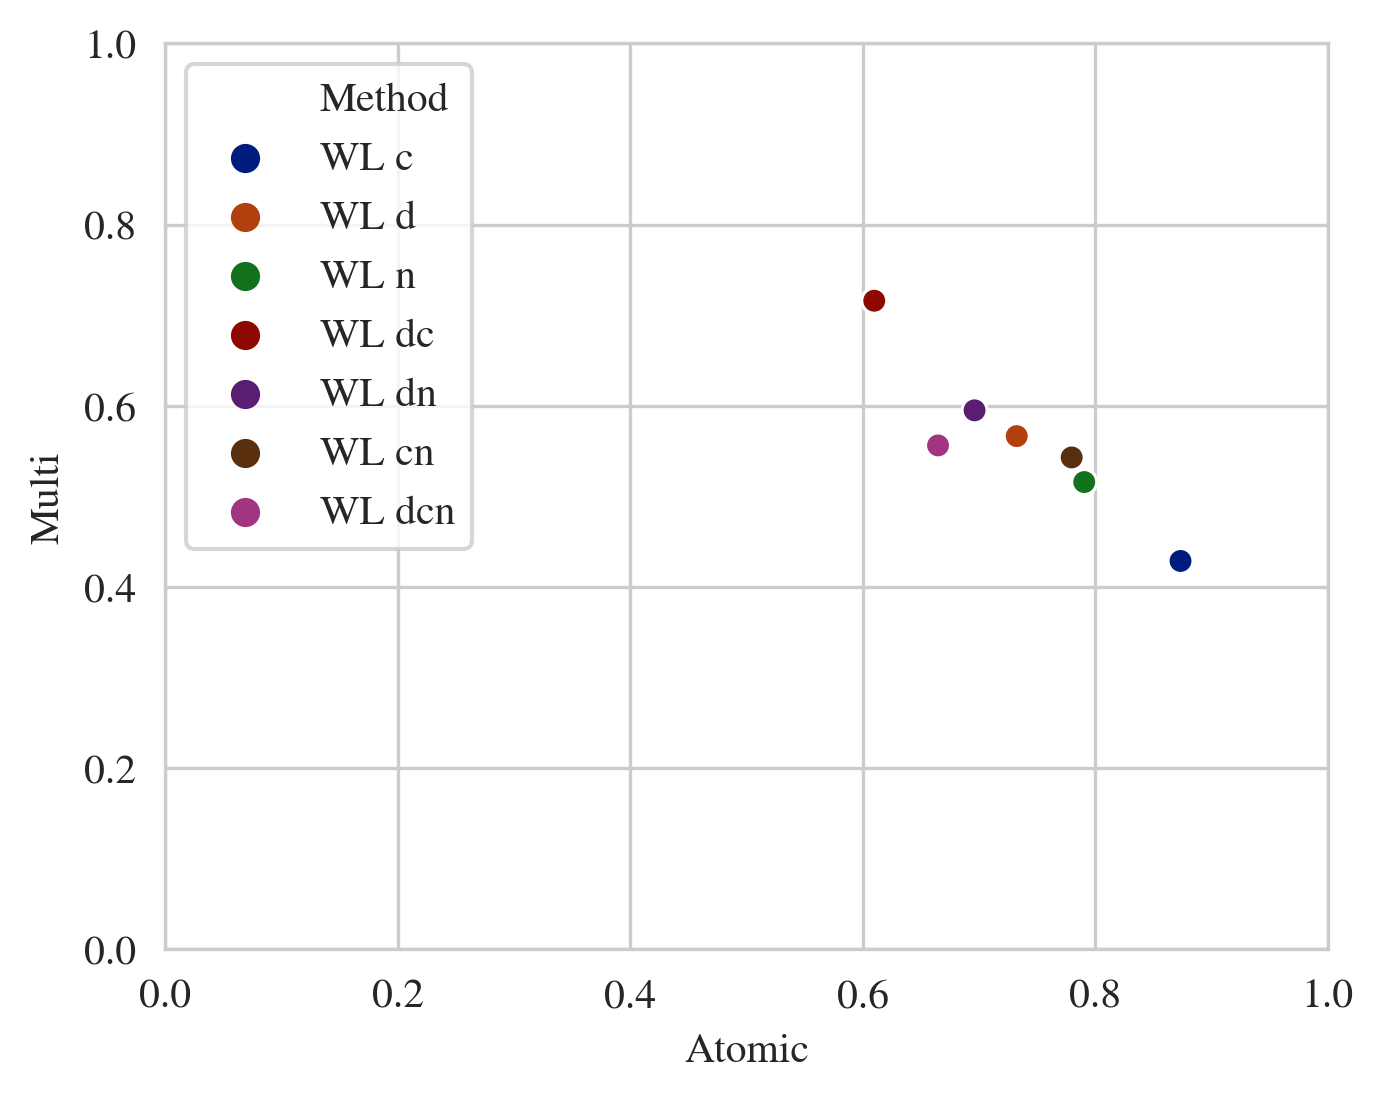

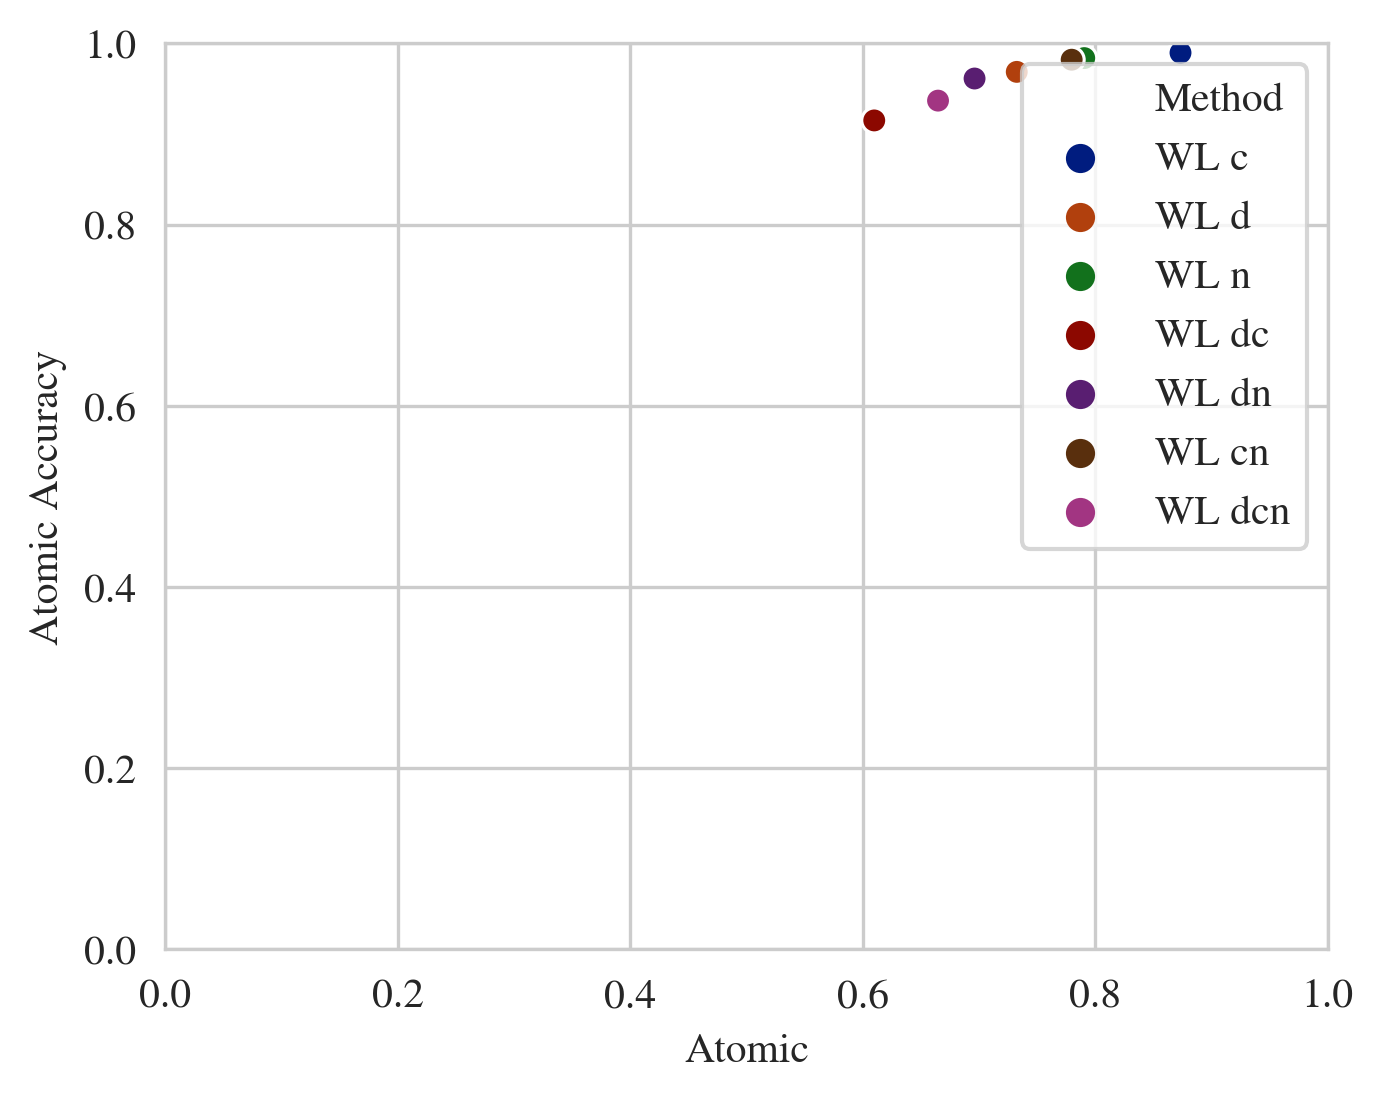

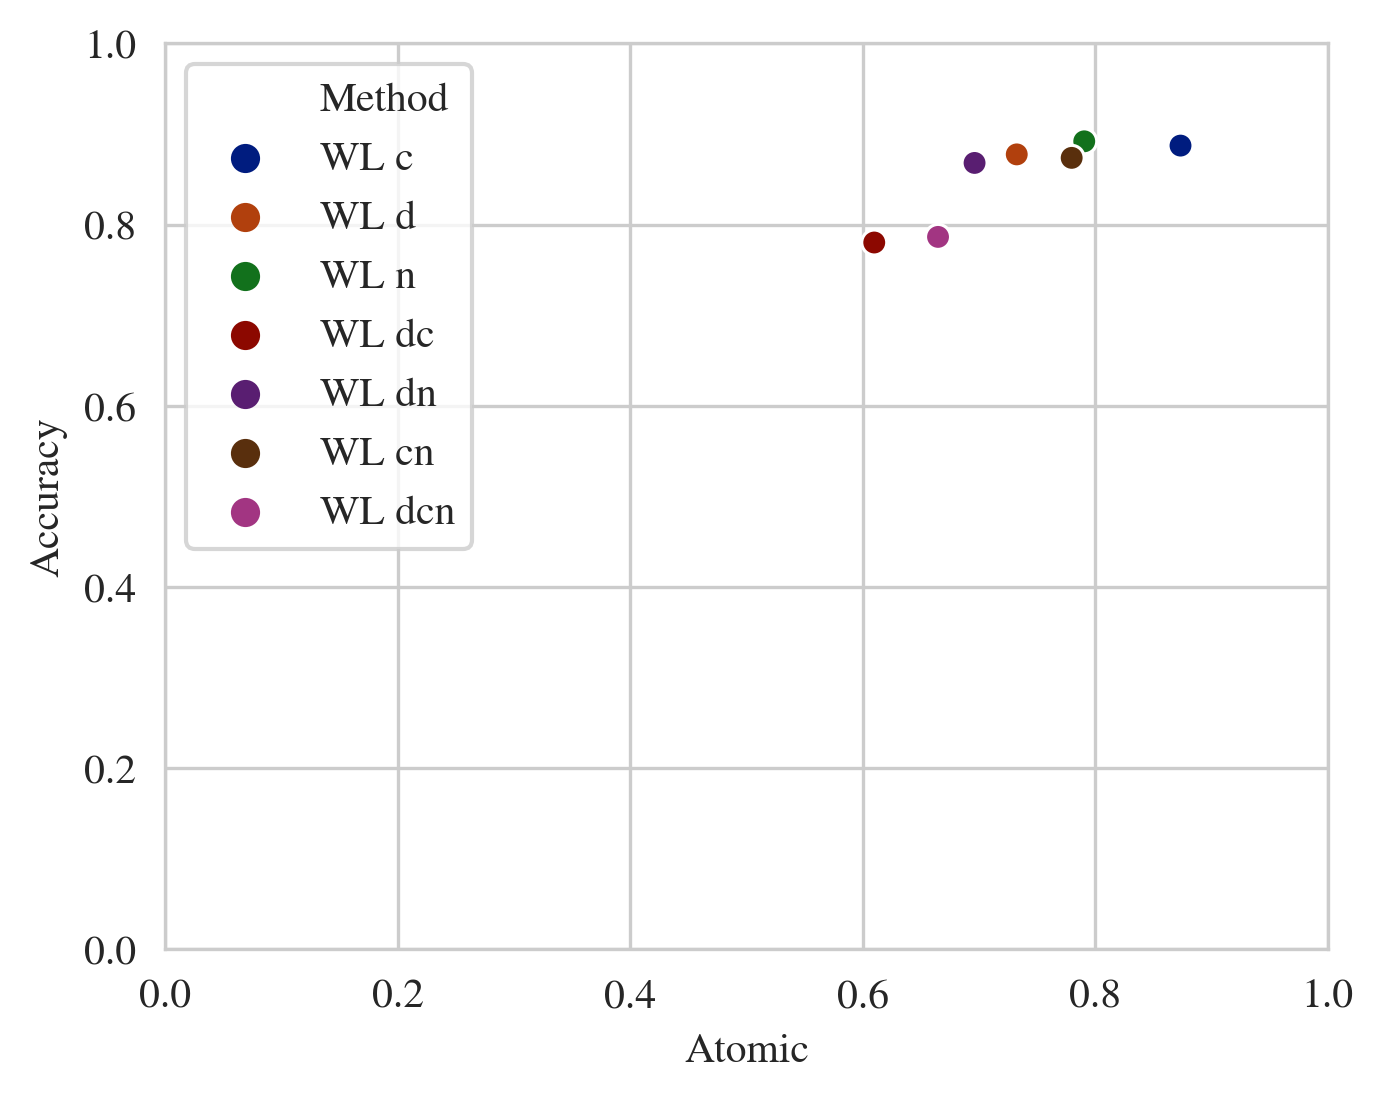

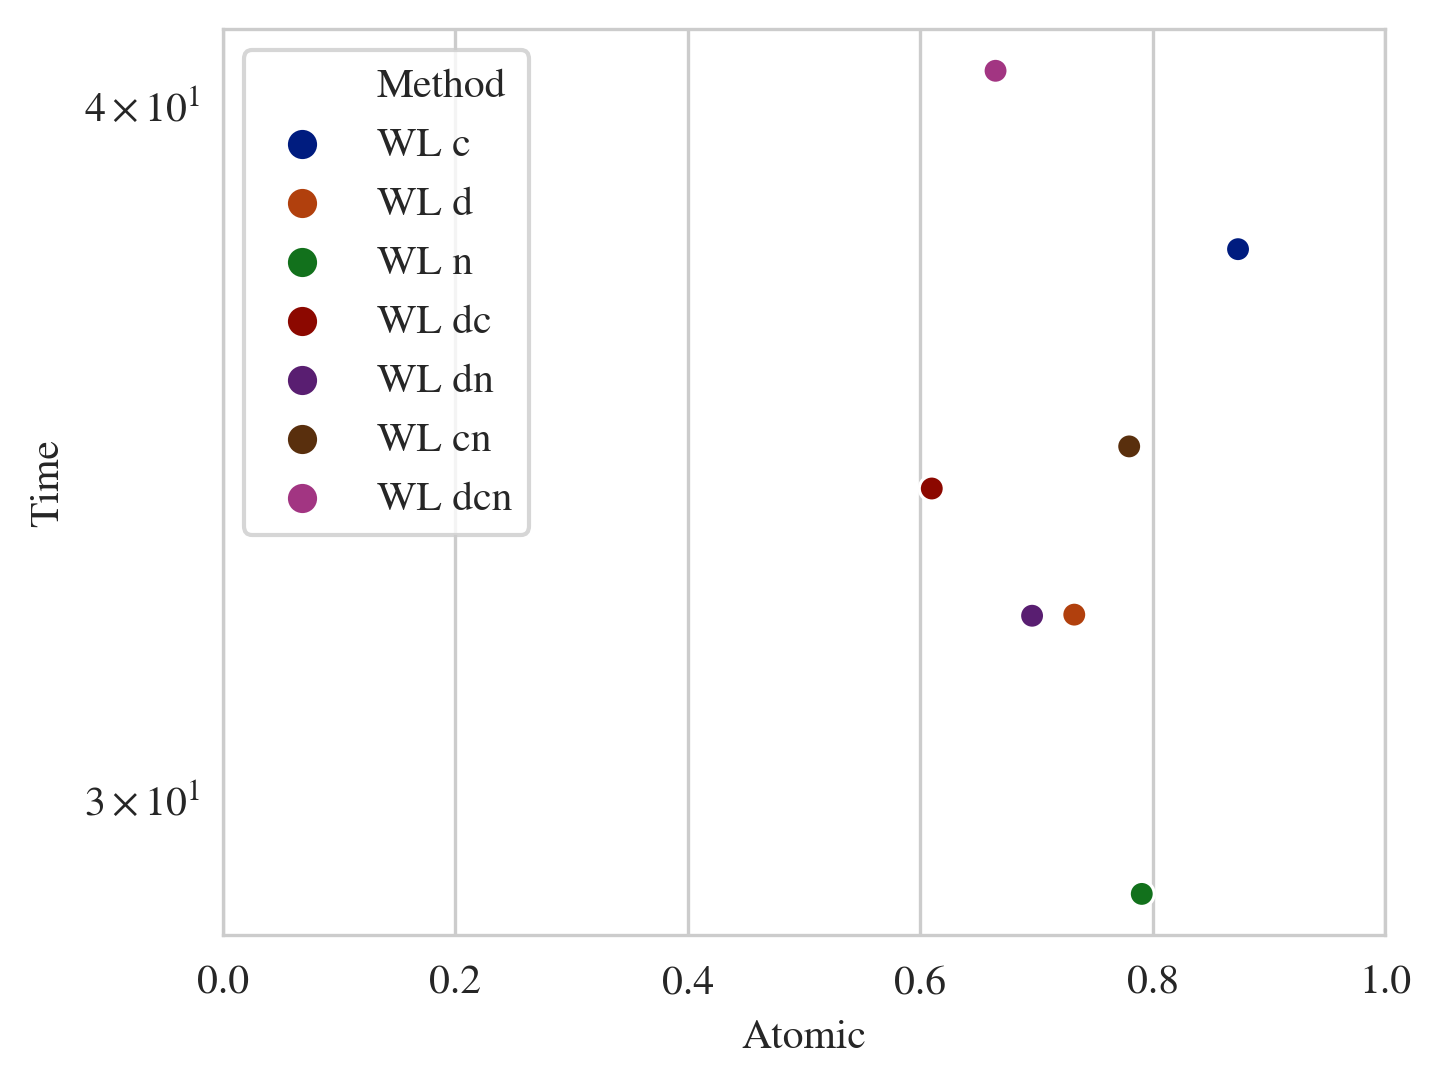

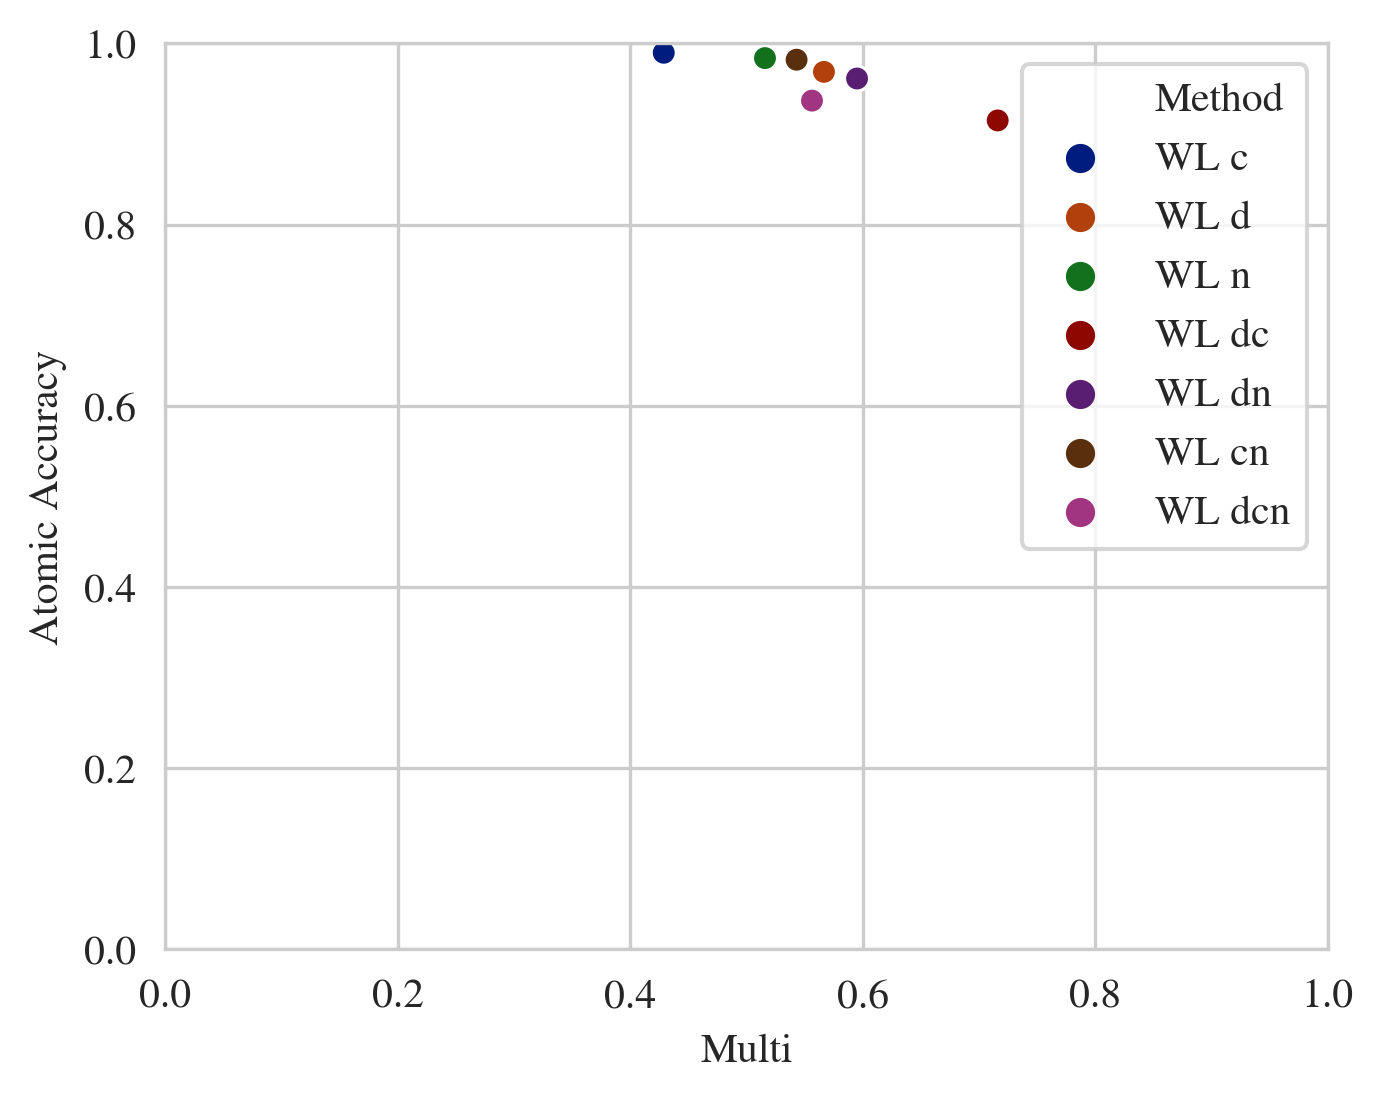

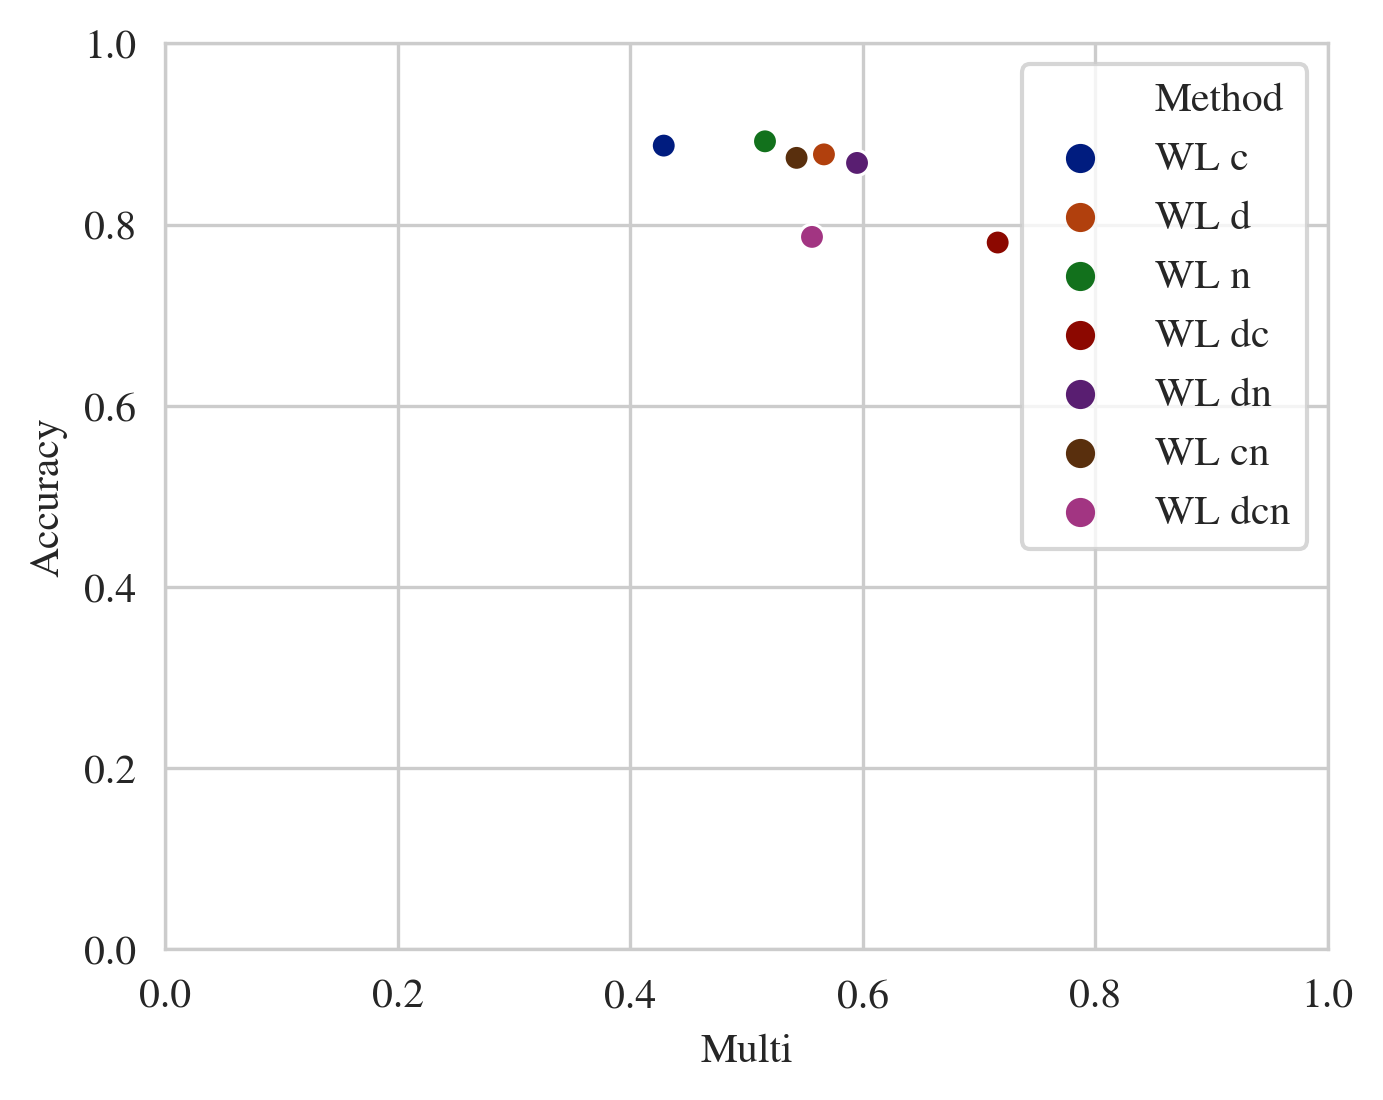

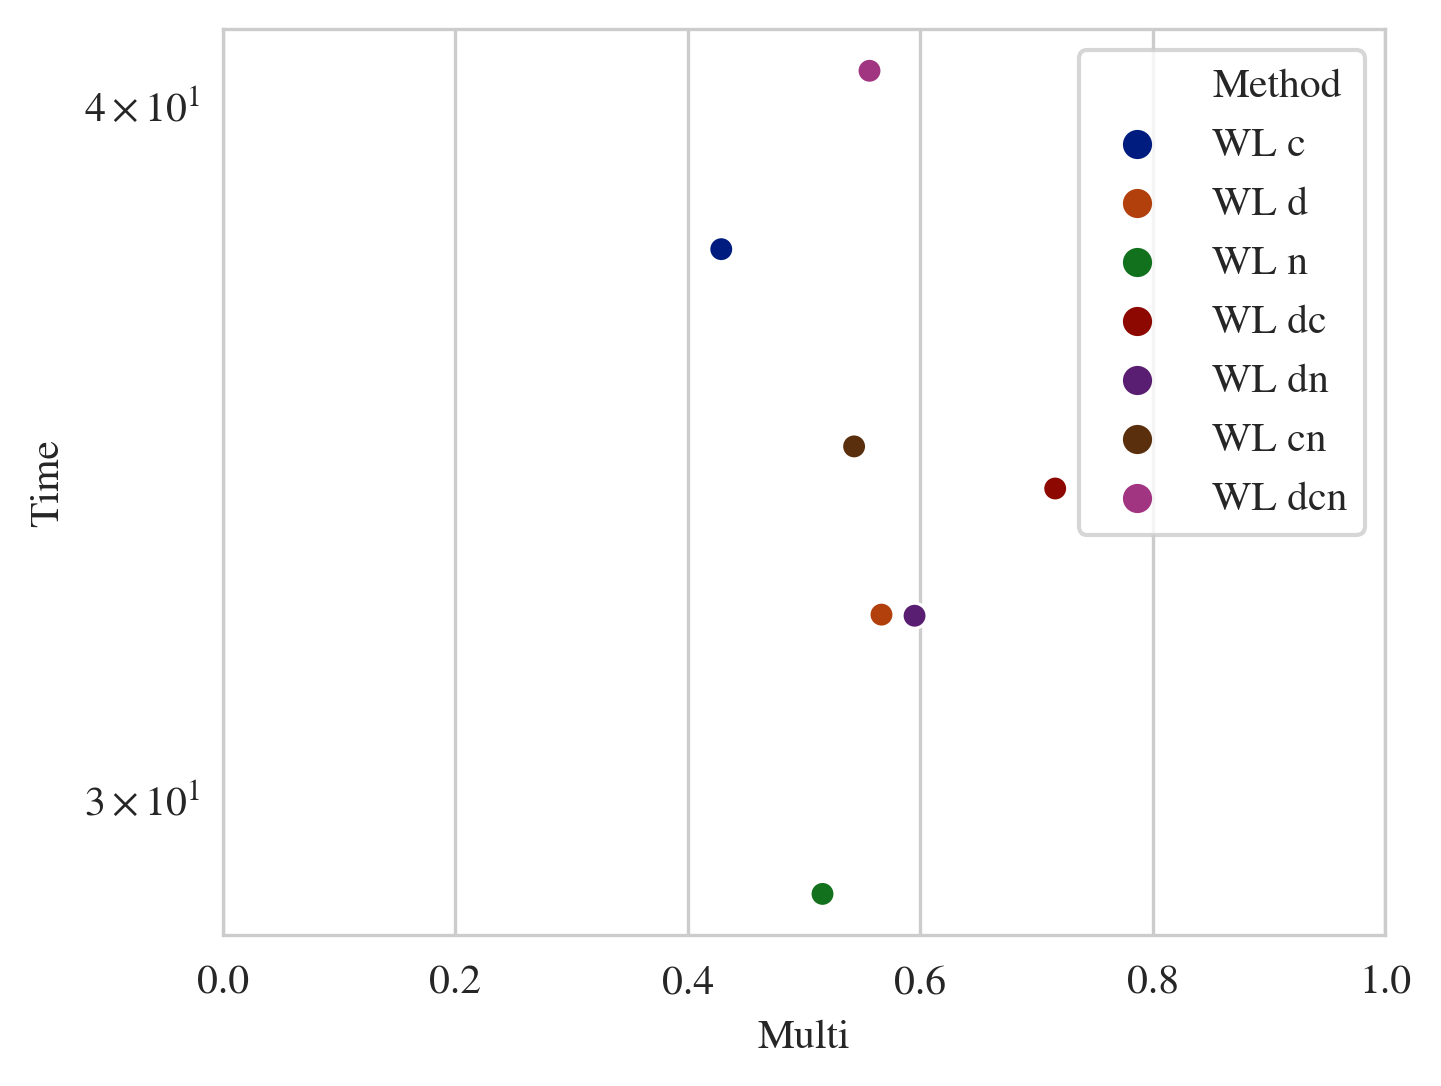

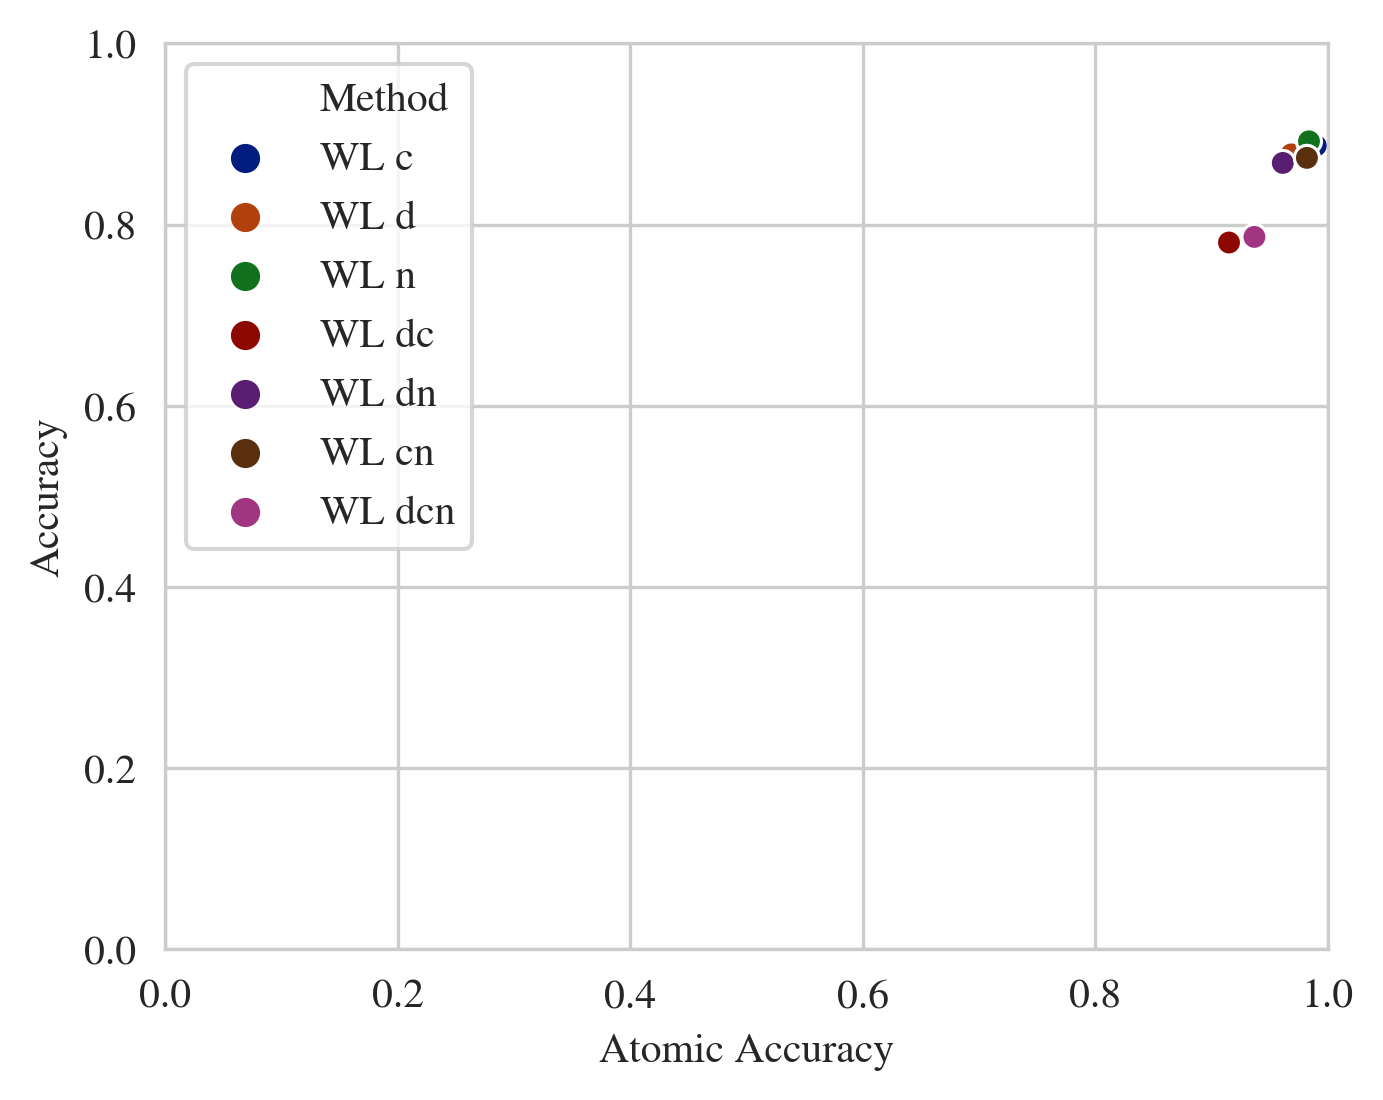

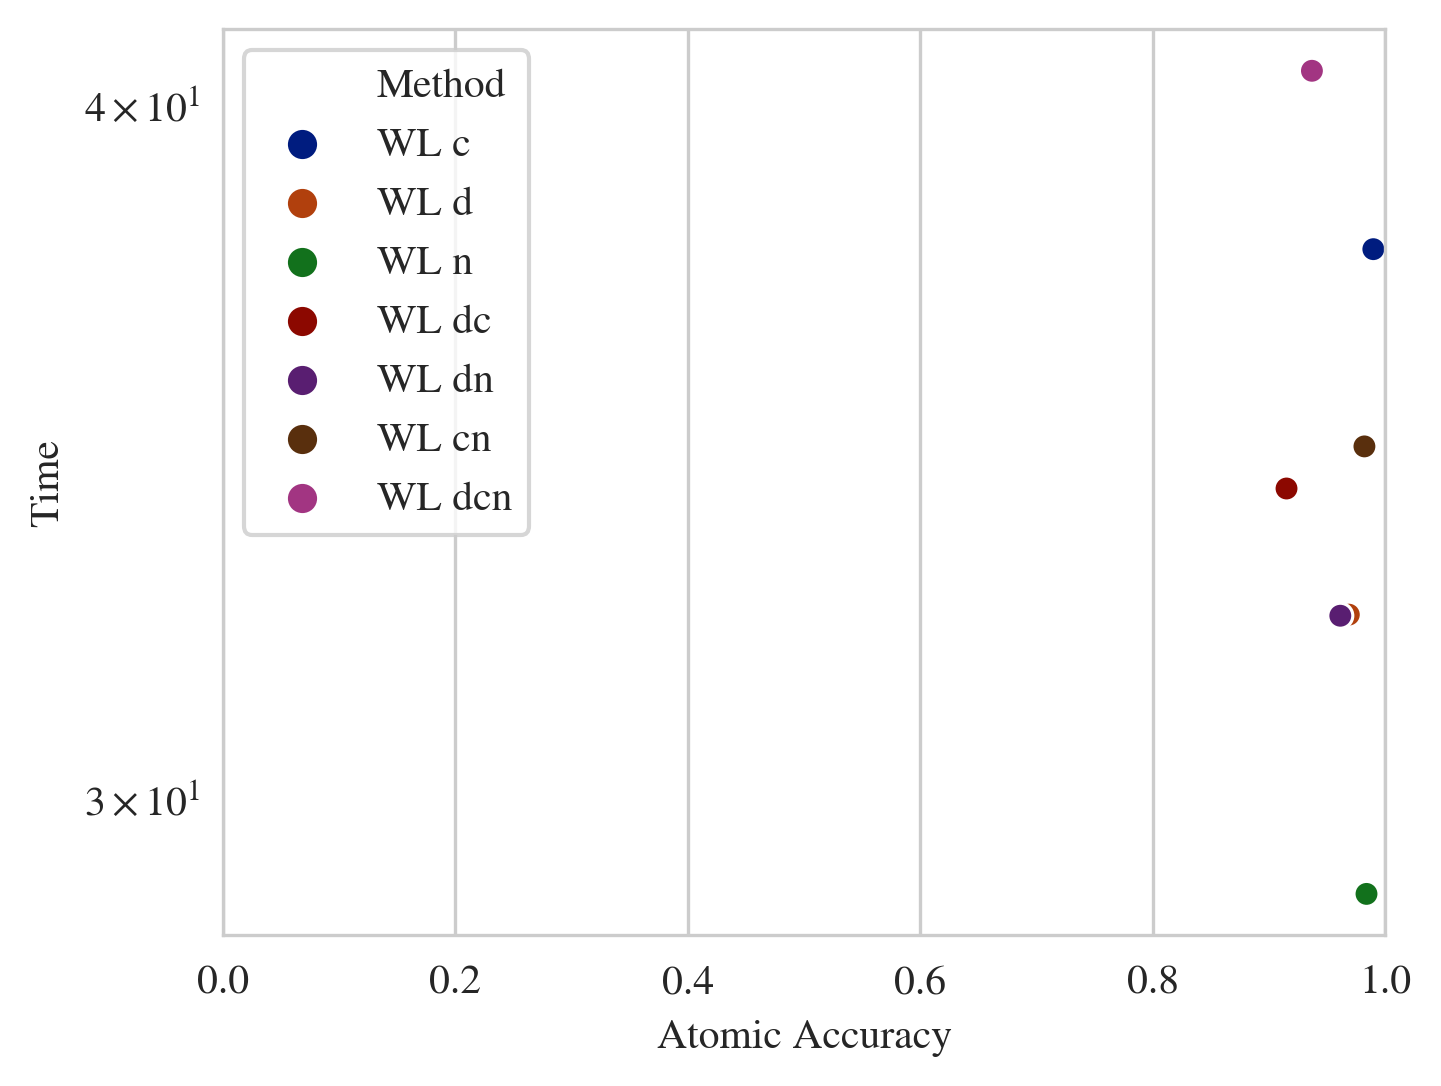

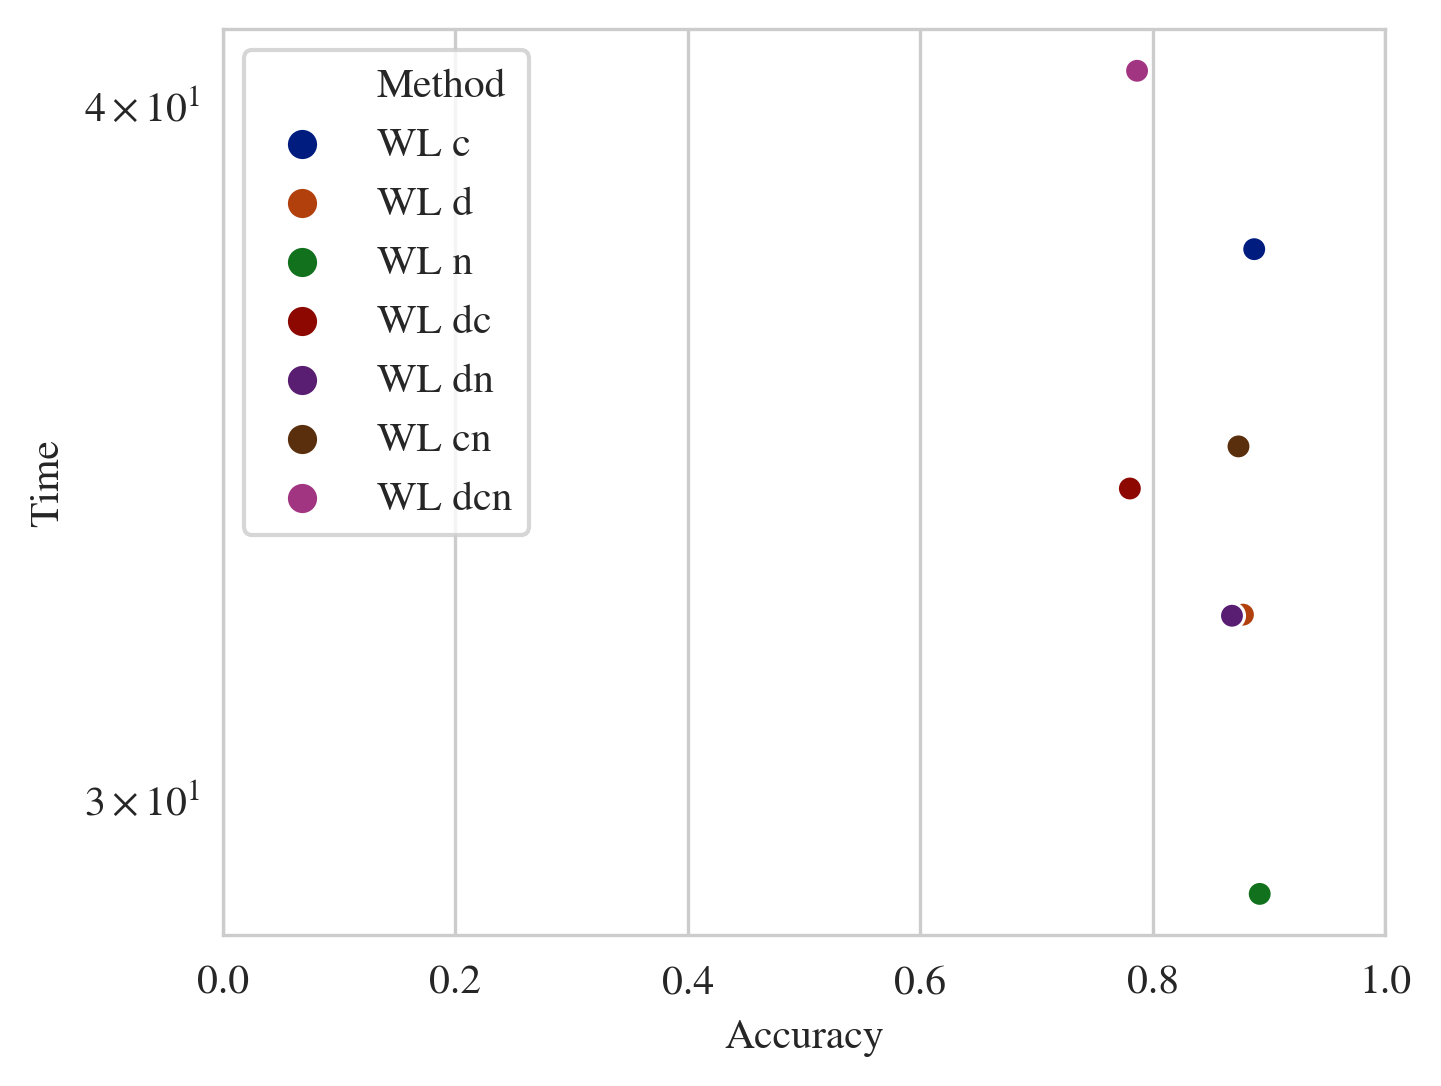

In [10]:
for x, y in itertools.combinations(['Atomic', 'Multi', 'Atomic Accuracy', 'Accuracy', 'Time'], 2):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.gca()
    sns.scatterplot(data=results_df, x=x, y=y, hue="Method", palette=palette, ax=ax)
    
    if y != "Time":
        plt.ylim((0, 1))
    else:
        plt.yscale("log")
    plt.xlim((0, 1))
    plt.savefig("Comparison_%s_%s_ablation.pdf" % (x, y), 
                #This is simple recomendation for publication plots
                dpi=1000, 
                # Plot will be occupy a maximum of available space
                bbox_inches='tight', 
               )